<a href="https://colab.research.google.com/github/shin0105/4YP/blob/master/ARIMA_stock_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing required packages
!pip install GPyOpt
!pip install GPy
!pip install yfinance

In [21]:
#importing packages
from pandas_datareader import data as pdr
import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas import datetime
from sklearn.metrics import mean_squared_error
import GPy
import GPyOpt

In [37]:
#downloading data (TSLA stock price)
yf.pdr_override()
start_date = "2021-12-14"
end_date = "2023-01-14"
TSLA = yf.Ticker("TSLA")
df = TSLA.history(start=start_date, end=end_date, actions=False)
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-12-14 00:00:00-05:00,315.000000,322.136658,310.000000,319.503326,70806300
2021-12-15 00:00:00-05:00,317.736664,326.250000,309.416656,325.329987,75169200
2021-12-16 00:00:00-05:00,331.500000,331.660004,307.283325,308.973328,82771500
2021-12-17 00:00:00-05:00,304.923340,320.220001,303.013336,310.856659,100437300
2021-12-20 00:00:00-05:00,303.566681,307.230011,297.796661,299.980011,56480100


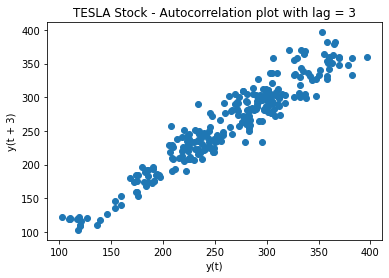

In [38]:
#checking cross-correlation
plt.figure()
lag_plot(df['Open'], lag=3)
plt.title('TESLA Stock - Autocorrelation plot with lag = 3')
plt.show()

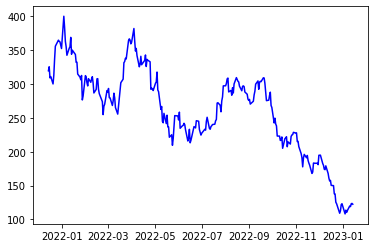

In [39]:
#plotting Close price
orig = plt.plot(df["Close"], color='blue')

In [40]:
#train, test data split (ratio = 7:3)
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)

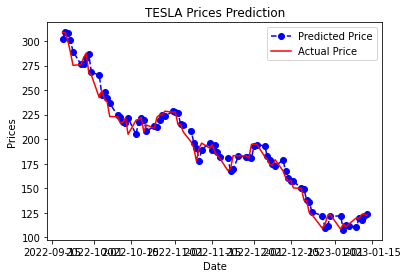

In [41]:
#plotting predicted value vs actual value
test_set_range = df[int(len(df)*0.7):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

In [44]:
#search domain
bounds = [ {'name': 'p', 'type': 'discrete', 'domain': (0,1,2,3,4)},
        {'name': 'd', 'type': 'discrete', 'domain': (0,1,2)},
        {'name': 'q', 'type': 'discrete', 'domain': (0,1,2,3,4)}
      ]

#splitting train,test data (ratio = 7:3)
train_data, test_data = df[0:int(len(df)*0.7)], df[int(len(df)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

#black-box function
def ARIMA_score(parameters):
  params = {
        'p': int(parameters[0][0]),
        'd':int(parameters[0][1]),
        'q':int(parameters[0][1])
    }
  
  for time_point in range(N_test_observations):
    model = ARIMA(history, order=(params['p'],params['d'],params['q']))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

  score = -mean_squared_error(test_data, model_predictions)

  print(params)
  print(score)

  return score

In [45]:
kernel = GPy.kern.Matern32(input_dim=1, variance=1.0, lengthscale=1.0)

optimizer = GPyOpt.methods.BayesianOptimization(f=ARIMA_score, 
                                                domain=bounds,
                                                acquisition_type ='EI',
                                                initial_design_numdata = 5,
                                                model_type='GP',
                                                maximize=True,
                                                kernel=kernel
                                                )

optimizer.run_optimization(max_iter=20)

#minimum MSE
MSE_min=optimizer.fx_opt
#best parameters
params_min=optimizer.x_opt
print(MSE_min)
print(params_min)

{'p': 3, 'd': 0, 'q': 0}
-76.96250643999532


ValueError: ignored